In [29]:
library(tidyverse)

In [48]:
orig <- read.csv('./hw2/training.csv', sep = ',')
head(orig, n=3)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,⋯,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,Sales,1,2,Life Sciences,1,2,Female,⋯,3,1,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,Research & Development,8,1,Life Sciences,2,3,Male,⋯,4,4,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,Research & Development,2,2,Other,4,4,Male,⋯,3,2,0,7,3,3,0,0,0,0


In [31]:
colnames(orig)

[1] "Age"                      "Attrition"               
 [3] "BusinessTravel"           "Department"              
 [5] "DistanceFromHome"         "Education"               
 [7] "EducationField"           "EmployeeNumber"          
 [9] "EnvironmentSatisfaction"  "Gender"                  
[11] "JobInvolvement"           "JobLevel"                
[13] "JobRole"                  "JobSatisfaction"         
[15] "MaritalStatus"            "MonthlyIncome"           
[17] "NumCompaniesWorked"       "PerformanceRating"       
[19] "RelationshipSatisfaction" "StockOptionLevel"        
[21] "TotalWorkingYears"        "TrainingTimesLastYear"   
[23] "WorkLifeBalance"          "YearsAtCompany"          
[25] "YearsInCurrentRole"       "YearsSinceLastPromotion" 
[27] "YearsWithCurrManager"

In [49]:
unique(orig[, 'JobRole'])

[1] "Sales Executive"           "Research Scientist"       
[3] "Laboratory Technician"     "Healthcare Representative"
[5] "Manager"                   "Manufacturing Director"   
[7] "Sales Representative"      "Research Director"        
[9] "Human Resources"

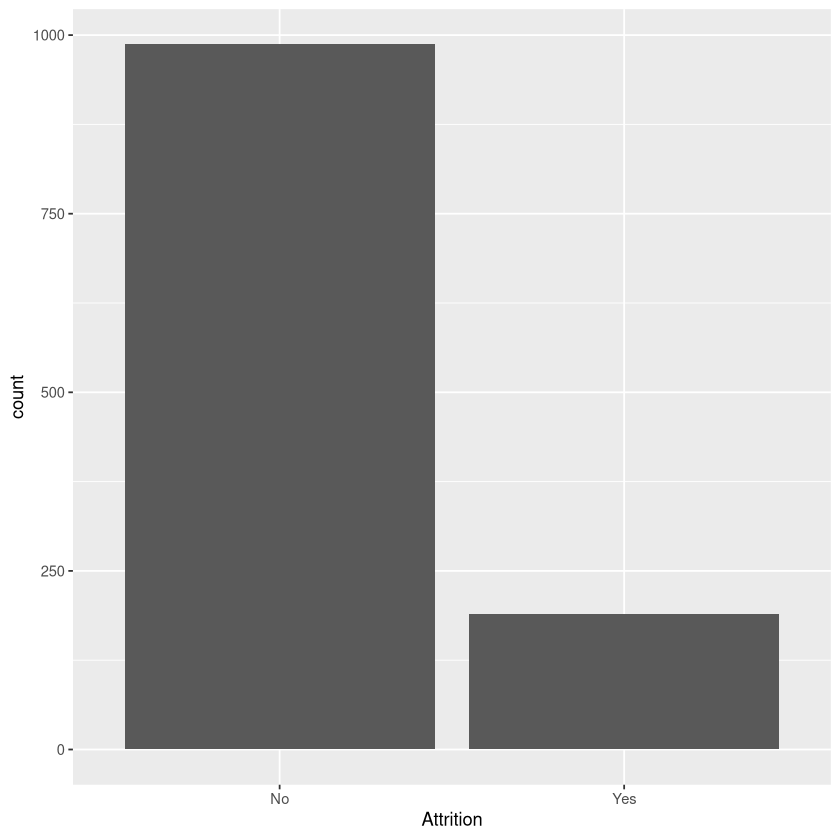

In [32]:
ggplot(orig, aes(x = Attrition)) + geom_bar()

In [33]:
set_col_to_factor <- function(df, ...){
  cols <- unlist(list(...))
  for(col in cols){
    df[, col] <- as.factor(df[, col])
  }
  return(df)
}
set_col_to_integer <- function(df, ...){
  cols <- unlist(list(...))
  for(col in cols) {
    df[, col] <- as.integer(df[, col])
  }
  return(df)
}
set_col_to_numeric <- function(df, ...){
  cols <- unlist(list(...))
  for(col in cols){
    df[, col] <- as.numeric(df[, col])
  } 
  return (df)
}
set_col_to_category <- function(df, old_col, new_col, mapper){
  df[new_col] <- as.factor(mapper(df[old_col]))
  return(df)
}

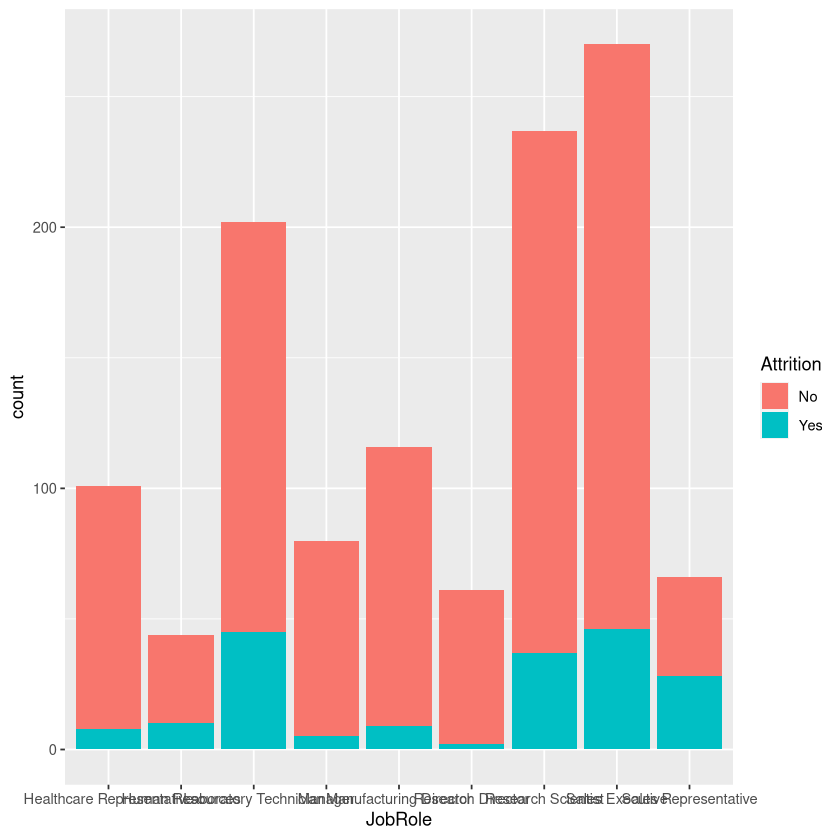

In [50]:
ggplot(orig, aes(x = JobRole, fill = Attrition)) + geom_bar()

In [35]:
build_fold_indices <- function(fold) {
  test_fold <- 1:fold
  shifted <- (test_fold + 1)
  valid_fold <- ifelse((shifted > fold), shifted %% fold, shifted)
  fold_indices <- data.frame(test = test_fold, valid = valid_fold)
  
  return(fold_indices)
}

pick_out_indices <- function(total_rows, fold, ...) {
  indices <- c()
  
  for (i in list(...)) {
    indices <- append(indices, seq(i, total_rows, fold))
  }
  
  indices <- unique(indices)
  
  return(indices)
}

get_by_exclude <- function(df, fold, ...) {
  total_rows <- nrow(df)
  exclude <- pick_out_indices(total_rows, fold, ...)
  excluded <- df[-exclude,]
  
  return(excluded)
}

get_by_index <- function(df, fold, ...) {
  total_rows <- nrow(df)
  
  include <- pick_out_indices(total_rows, fold, ...)
  included <- df[include,]
  
  return(included)
}

subset_by_fold <- function(df, fold, index, indices){
  training_frame <- get_by_exclude(df,
                                   fold,
                                   indices[index, ]$test,
                                   indices[index, ]$valid)
  validation_frame <- get_by_index(df, fold, indices[index, ]$valid)
  testing_frame <- get_by_index(df, fold, indices[index, ]$test)
  
  return(list(training=training_frame,
              validation=validation_frame,
              testing=testing_frame))
}

shuffle_frame <- function(df){
   set.seed(28657)
   shf_rows <- sample(nrow(df))
   shf_train <- df[shf_rows, ]
   return(shf_train)
}

remove_cols <- function(df, ...){
  cols <- unlist(list(...))
  new_df <- df[, !(names(df) %in% cols)]
  return(new_df)
}

In [36]:
gender_mapper <- function(gender){
  return(ifelse(gender == 'Male', 1, 0))
}
age_mapper <- function(age) {
  return(ifelse(age <= 30, 2,
                ifelse(31<= age && age <= 45, 3, 1)))
}
travel_mapper <- function(travel) {
  return(ifelse(travel == 'Travel_Rarely', 3,
                ifelse(travel == 'Travel_Frequently', 2, 1)))
}
department_mapper <- function(department){
  return(ifelse(department == 'Human Resources', 1,
               ifelse(department == 'Sales', 2, 3)))
}
field_mapper <- function(field) {
  # 'Medical''Other''Marketing''Human Resources''Technical Degree'
  return(ifelse(field=='Life Sciences', 6,
               ifelse(field=='Medical', 5,
                     ifelse(field=='Technical Degree', 4,
                           ifelse(field=='Marketing', 3,
                                 ifelse(field=='Human Resources', 2, 1))))))
}
job_mapper <- function(job){
  
}

wrangling_process <- function(df){
  df <- set_col_to_category(df, 'Gender', 'Gender_1', gender_mapper)
  df <- set_col_to_category(df, 'Age', 'Age_1', age_mapper)
  df <- set_col_to_category(df, 'BusinessTravel', 'BusinessTravel_1', travel_mapper)
  df <- set_col_to_category(df, 'Department', 'Department_1', department_mapper)
  df <- set_col_to_category(df, 'EducationField', 'EducationField_1', field_mapper)
  df <- set_col_to_category(df, 'JobRole', 'JobRole_1', job_mapper)
  df <- remove_cols(df, 'Gender', 'Age', 'BusinessTravel', 'Department', 'EducationField')
  return(df)
}

In [37]:
fold <- 3
index <- 1
df <- shuffle_frame(wrangling_process(orig))
fold_indices <- build_fold_indices(fold)
splitted_frames <- subset_by_fold(df, fold, index, fold_indices)

In [38]:
library(rpart)

train_dt <- function(df, depth=5) {
  model <- rpart(
    Attrition ~ .,
    data = df,
    control = rpart.control(maxdepth = depth),
    method = "class"
  )
  return (model)
}

predict_dt <- function(model, df) {
  pred_frame <- predict(model, df, type = "class")
  return (pred_frame)
}

In [39]:
library(randomForest)

train_rf <- function(df) {
   model <- randomForest(
     Attrition ~ .,
     data = df,
     mtry = 9,
     importance=TRUE,
     proximity=TRUE,
     ntree=500)

   return (model)
 }

 predict_rf <- function(model, df) {
   pred_frame <- predict(model, df)

   return (pred_frame)
 }

In [40]:
build_cm <- function(df, pred) {
  result_frame <- data.frame(truth = df$Attrition,
                             pred = pred)
  result_table <- table(result_frame)
  return(result_table)
}

cal_pred_result <- function(cM) {
  true_col <- 2
  false_col <- 1
  positive_row <- 2
  negative_row <- 1
  
  TP <- cM[positive_row, ][true_col]
  FN <- cM[positive_row, ][false_col]
  TN <- cM[negative_row, ][false_col]
  FP <- cM[negative_row, ][true_col]
  
  result <- c(TP, FP, TN, FN)
  names(result) = c("TP", "FP", "TN", "FN")
  return(result)
}

get_rounded <- function(value, round_digits = 2) {
  return(round(value, digits = round_digits))
}

cal_accu <- function(pred_result) {
  TP <- unname(pred_result["TP"])
  FN <- unname(pred_result["FN"])
  TN <- unname(pred_result["TN"])
  FP <- unname(pred_result["FP"])
  total_rows = TP + FN + TN + FP
  accuracy <- (TP + TN) / total_rows
  return(get_rounded(accuracy))
}

cal_sensitivity <- function(pred_result) {
  TP <- unname(pred_result["TP"])
  FN <- unname(pred_result["FN"])
  sensitivity <- TP / (TP + FN)
  return(get_rounded(sensitivity))
}

cal_specificity <- function(pred_result) {
  TN <- unname(pred_result["TN"])
  FP <- unname(pred_result["FP"])
  specificity <- TN / (TN + FP)
  return(get_rounded(specificity))
}

cal_F1 <- function(pred_result) {
  precision <- cal_precision(pred_result)
  recall <- cal_sensitivity(pred_result)
  F1 <- (2 * precision * recall) / (precision + recall)
  return(get_rounded(F1))
}

cal_precision <- function(pred_result) {
  TP <- unname(pred_result["TP"])
  FP <- unname(pred_result["FP"])
  precision <- TP / (TP + FP)
  return(get_rounded(precision))
}

evaluate_model <- function(df, pred){
  predict_cm <- build_cm(df, pred)
  predict_result <- cal_pred_result(predict_cm)
  accu <- cal_accu(predict_result)
  preci <- cal_precision(predict_result)
  sens <- cal_sensitivity(predict_result)
  recl <- sens
  spec <- cal_specificity(predict_result)
  f1 <- cal_F1(predict_result)
  
  return(list(cm=predict_cm,
              result=predict_result,
              accuracy=accu,
              recall=recl,
              precision=preci,
              sensitivity=sens,
              specificity=spec,
              F1=f1))
}

In [41]:
trainer <- (function(df) train_rf(df))
predictor <- (function(model, df) predict_rf(model, df))

model <- trainer(splitted_frames$training)

pred_train <- predictor(model, splitted_frames$training)
result_train <- evaluate_model(splitted_frames$training, pred_train)
pred_valid <- predictor(model, splitted_frames$validation)
result_valid <- evaluate_model(splitted_frames$validation, pred_valid)
pred_test <- predictor(model, splitted_frames$testing)
result_test <- evaluate_model(splitted_frames$testing, pred_test)

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”
Warning message in mean.default(y):
“argument is not numeric or logical: returning NA”


ERROR: Error in y - ymean: non-numeric argument to binary operator


In [42]:
print('train result:')
print(result_train)

[1] "train result:"
$cm
     pred
truth  No Yes
  No  331   0
  Yes   0  61

$result
 TP  FP  TN  FN 
 61   0 331   0 

$accuracy
[1] 1

$recall
[1] 1

$precision
[1] 1

$sensitivity
[1] 1

$specificity
[1] 1

$F1
[1] 1



In [43]:
print('validation:')
print(result_valid)

[1] "validation:"
$cm
     pred
truth  No Yes
  No  323   4
  Yes  54  11

$result
 TP  FP  TN  FN 
 11   4 323  54 

$accuracy
[1] 0.85

$recall
[1] 0.17

$precision
[1] 0.73

$sensitivity
[1] 0.17

$specificity
[1] 0.99

$F1
[1] 0.28



In [44]:
print('testing')
print(result_test)

[1] "testing"
$cm
     pred
truth  No Yes
  No  318  11
  Yes  58   6

$result
 TP  FP  TN  FN 
  6  11 318  58 

$accuracy
[1] 0.82

$recall
[1] 0.09

$precision
[1] 0.35

$sensitivity
[1] 0.09

$specificity
[1] 0.97

$F1
[1] 0.14



In [45]:
library(ggbiplot)
draw_pca <- function(df, x, y){
  ggbiplot(df.pca, choices=c(x, y),
          obs.scale=1, var.scale=1,
          ellipse=TRUE, ellipse.prob=0.68,
          circle=TRUE, circle.prob=0.68,
          groups=df$Attrition)
}

In [46]:
colnames(df)

[1] "Attrition"                "DistanceFromHome"        
 [3] "Education"                "EmployeeNumber"          
 [5] "EnvironmentSatisfaction"  "JobInvolvement"          
 [7] "JobLevel"                 "JobRole"                 
 [9] "JobSatisfaction"          "MaritalStatus"           
[11] "MonthlyIncome"            "NumCompaniesWorked"      
[13] "PerformanceRating"        "RelationshipSatisfaction"
[15] "StockOptionLevel"         "TotalWorkingYears"       
[17] "TrainingTimesLastYear"    "WorkLifeBalance"         
[19] "YearsAtCompany"           "YearsInCurrentRole"      
[21] "YearsSinceLastPromotion"  "YearsWithCurrManager"    
[23] "Gender_1"                 "Age_1"                   
[25] "BusinessTravel_1"         "Department_1"            
[27] "EducationField_1"

In [47]:
head(df, n=3)

,Attrition,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,⋯,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Gender_1,Age_1,BusinessTravel_1,Department_1,EducationField_1
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>
631,Yes,25,3,1108,1,2,1,Research Scientist,2,Single,⋯,3,2,2,2,2,1,3,3,3,5
408,No,3,1,714,4,4,2,Sales Executive,4,Divorced,⋯,3,6,5,0,4,0,2,2,2,5
526,No,14,1,924,3,3,2,Healthcare Representative,4,Married,⋯,2,16,8,4,11,1,3,3,3,6


In [ ]:
df.log <- log(df[, c('Attrition', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeNumber',
                     'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
                     'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked', 'PerformanceRating', 
                     'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 
                     'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 
                     'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Gender_1', 'Age_1', 'BusinessTravel_1',
                     'Department_1')])
df.pca <- prcomp()